# Sentiment Analysis to predict fluctuations in Bitcoin markets

## *Abstract*

This study examines the impact of sentiment on the fluctuations in the cryptocurrency market and specifically the dominant cryptocurrency i.e, Bitcoin. We examine how the prices fluctuate based on the polarity and subjectivity scores of news headlines extracted from the CNBC website. Furthermore, we also consider the Fear and Greed Index and try to predict the price fluctuations of Bitcoin based on the aforementioned features. We perform binary classification on the target variable column using popular machine learning models such as Random Forest, Decision Tree, Support Vector Machines, and Naive Bayes.  We have obtained an accuracy of 75.4% on the training set and 72.11% on the testing set using Random Forest Classifier. As is indicative, when the equity market investors’ sentiment is bearish, cryptocurrency prices rise, indicating that cryptocurrency can act as an alternative avenue for investment.

In [1]:
# # Uncomment during first run >>

!pip install contractions
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

     |████████████████████████████████| 106 kB 5.4 MB/s 
     |████████████████████████████████| 287 kB 10.4 MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [2]:
import pandas as pd
from nltk.corpus import stopwords
import unicodedata
from nltk.tokenize import word_tokenize # Can also use RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re
import contractions
import string
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from scipy import stats

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [46]:
df = pd.read_csv('final_data-v2.csv')

In [47]:
df = df.drop(['Unnamed: 0'], axis=1)

In [48]:
df.rename(columns = {'fear-and-greed-index':'FG'}, inplace = True)

In [49]:
df.head()

,Date,News,Price,FG
0,4/10/2022,MicroStrategy CEO Michael Saylor speaks with C...,0,39
1,4/8/2022,My first experience with one of the men Peter ...,0,54
2,4/8/2022,Cryptocurrency was initially created to sidest...,0,54
3,4/8/2022,"William Quigley, Tether and Worldwide Asset Ex...",0,54
4,4/8/2022,CNBC’s Kate Rooney speaks to ARK Invest CEO Ca...,0,54


In [50]:
df.tail()

,Date,News,Price,FG
757,6/25/2019,The new safety trade. Would you rather buy gol...,1,86
758,6/25/2019,CNBC’s Seema Mody reports on bitcoin’s surge a...,1,86
759,6/19/2019,Bitcoin appears to be back in business.Having ...,1,81
760,6/19/2019,Bitcoin appears to be back in business.Having ...,1,81
761,6/17/2019,"Bitcoin leaped across the $9,000 mark on Sunda...",1,77


In [51]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst = True, infer_datetime_format = True)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762 entries, 0 to 761
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    762 non-null    datetime64[ns]
 1   News    759 non-null    object        
 2   Price   762 non-null    int64         
 3   FG      762 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 23.9+ KB


In [53]:
df.isnull().sum()

Date     0
News     3
Price    0
FG       0
dtype: int64

In [54]:
df.dropna(axis = 0, inplace = True)

In [55]:
df.describe()

,Price,FG
count,759.000000,759.000000
mean,0.515152,56.487484
std,0.500100,19.111519
min,0.000000,3.000000
25%,0.000000,41.000000
50%,1.000000,60.000000
75%,1.000000,71.000000
max,1.000000,92.000000


In [56]:
df.describe(include='object')

,News
count,759
unique,709
top,CNBC Crypto World features the latest news and...
freq,9


In [57]:
df['Price'].value_counts()

1    391
0    368
Name: Price, dtype: int64

In [58]:
df.reset_index(inplace = True, drop = True)

In [59]:
lemma = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [60]:
# Function to perform text preparation on the given text data
def text_prep(x: str) -> list:
     corp = str(x).lower()
     corp = contractions.fix(corp)
     corp = re.sub('[^a-zA-Z]+',' ', corp).strip() 
     tokens = word_tokenize(corp)
     words = [t for t in tokens if t not in stop_words]
     lemmatize = [lemma.lemmatize(w) for w in words]
     return lemmatize

prep_tag = [text_prep(i) for i in df['News']]
df["prep_text"] = prep_tag
df['prep_text'] = [" ".join(i) for i in df['prep_text']]

In [61]:
df.sample(n=5)

,Date,News,Price,FG,prep_text
43,2022-02-23,"Juthica Chou, head of OTC options trading at K...",0,40,juthica chou head otc option trading kraken di...
9,2022-06-04,CNBC’s Kate Rooney reports on the Bitcoin 2022...,0,69,cnbc kate rooney report bitcoin conference miami
656,2020-12-24,"Michael Saylor, Microstrategy CEO, discusses h...",1,71,michael saylor microstrategy ceo discus bitcoi...
741,2019-07-19,Venture capitalist Tim Draper told CNBC on Fri...,0,32,venture capitalist tim draper told cnbc friday...
108,2021-12-19,"For years, the U.S. government has maintained ...",0,33,year government maintained side hustle auction...


# VADER

In [62]:
# lets calculate the Sentiment from news articles

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

train_sentiments = []

for i in df['prep_text']:
    train_sentiments.append(sid.polarity_scores(i).get('compound'))
    
train_sentiments = np.asarray(train_sentiments)
df['polarity'] = pd.Series(data=train_sentiments)

In [63]:
df['polarity'].describe()

count    759.000000
mean       0.141251
std        0.341621
min       -0.871200
25%        0.000000
50%        0.128000
75%        0.361200
max        0.949300
Name: polarity, dtype: float64

# Using `TextBlob`

In [64]:
# def subjectivity(x):
#   return TextBlob(x).sentiment.subjectivity

In [65]:
# df['subjectivity'] = df['prep_text'].apply(lambda x: round(subjectivity(x),2))

In [66]:
df.sample(n=5)

,Date,News,Price,FG,prep_text,polarity
537,2021-02-22,"Giles Keating, director of Bitcoin Suisse, giv...",0,90,giles keating director bitcoin suisse give out...,0.0000
44,2022-02-23,A key investment case for bitcoin is deteriora...,0,40,key investment case bitcoin deteriorating geop...,-0.5423
487,2021-07-04,A Missouri man who used the cryptocurrency bit...,0,78,missouri man used cryptocurrency bitcoin try b...,-0.8000
375,2021-04-06,CNBC’s MacKenzie Sigalos reports from Miami wh...,0,34,cnbc mackenzie sigalos report miami world larg...,0.0000
509,2021-03-20,CNBC’s Kate Rooney explains how bitcoin is cre...,0,78,cnbc kate rooney explains bitcoin creating dil...,0.4767


In [68]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

f = pd.Series(df['FG'])
arr = f.values
arr = arr.reshape(-1, 1)
df['FG'] = sc.fit_transform(arr)

f = pd.Series(df['polarity'])
arr = f.values
arr = arr.reshape(-1, 1)
df['polarity'] = sc.fit_transform(arr)

# f = pd.Series(df['subjectivity'])
# arr = f.values
# arr = arr.reshape(-1, 1)
# df['subjectivity'] = sc.fit_transform(arr)

In [69]:
y = df['Price']
X = df.drop(['Date', 'News', 'Price', 'prep_text'], axis = 1)

# Removing Heteroscedasticity from the numerical variables
## Using 'Yeo-Johnson' Transformation

In [70]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')

for col in X.columns:
  X[col] = pt.fit_transform(X)

<Figure size 1008x720 with 0 Axes>

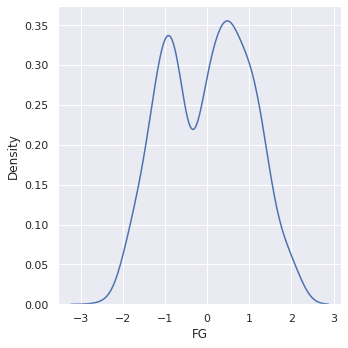

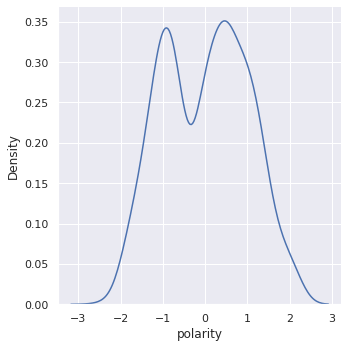

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (14, 10))
for col in X.columns:
  sns.displot(data = X[col], kind = "kde")

In [72]:
from sklearn.model_selection import train_test_split as tts

xtrain, xtest, ytrain, ytest = tts(X, y, random_state=1, train_size = 0.75)

In [73]:
xtrain

,FG,polarity
160,-0.655635,-0.662484
706,1.168516,1.174123
554,1.168516,1.174123
507,0.920420,0.919448
119,-1.459959,-1.446141
...,...,...
645,1.043727,1.045884
715,-0.749551,-0.754601
72,-1.417340,-1.404884
235,0.920420,0.919448


In [74]:
ytrain

160    1
706    1
554    1
507    0
119    0
      ..
645    1
715    0
72     1
235    1
37     1
Name: Price, Length: 569, dtype: int64

In [75]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(569, 2)
(569,)
(190, 2)
(190,)


In [76]:
np.nan_to_num(xtrain, copy = False)
np.nan_to_num(ytrain, copy = False)
np.nan_to_num(xtest, copy = False)
np.nan_to_num(ytest, copy = False)

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1])

In [77]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression()
log.fit(xtrain,ytrain)

LogisticRegression()

In [78]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(xtrain, ytrain)

GaussianNB()

In [79]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)

RandomForestClassifier()

In [80]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(xtrain, ytrain)

SVC()

In [81]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(xtrain, ytrain)

DecisionTreeClassifier()

In [82]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Gaussian Naive Bayes', 'Random Forest Classifier', 'Support Vector Machine', 'Decision Tree Classifier'],
    'Train Score': [round(log.score(xtrain, ytrain), 4)*100, 
              round(gnb.score(xtrain, ytrain), 4)*100, 
              round(rf.score(xtrain, ytrain), 4)*100, 
              round(svm.score(xtrain, ytrain), 4)*100, 
              round(dt.score(xtrain, ytrain), 4)*100],
    'Test Score': [round(log.score(xtest, ytest), 4)*100, 
              round(gnb.score(xtest, ytest), 4)*100, 
              round(rf.score(xtest, ytest), 4)*100, 
              round(svm.score(xtest, ytest), 4)*100, 
              round(dt.score(xtest, ytest), 4)*100]})
result_df = results.sort_values(by='Test Score', ascending=False).reset_index(drop = True)
result_df

,Model,Train Score,Test Score
0,Random Forest Classifier,76.10,74.74
1,Decision Tree Classifier,76.10,71.58
2,Support Vector Machine,59.05,61.58
3,Logistic Regression,58.88,60.53
4,Gaussian Naive Bayes,57.82,59.47


# Pruning Decision Tree and Random Forest

In [83]:
path = dt.cost_complexity_pruning_path(xtrain, ytrain)
alphas = path['ccp_alphas']

alphas

array([0.00000000e+00, 0.00000000e+00, 3.13274375e-06, 2.28242759e-05,
       8.01125581e-05, 8.78734622e-05, 9.58619588e-05, 1.02519039e-04,
       1.27033321e-04, 1.50640221e-04, 2.92010274e-04, 3.19539863e-04,
       3.34756047e-04, 3.42364138e-04, 5.13721779e-04, 6.02560884e-04,
       8.71797244e-04, 1.02082943e-03, 1.12980166e-03, 1.15833200e-03,
       1.17572855e-03, 1.46689865e-03, 1.70421260e-03, 1.75746924e-03,
       2.07040208e-03, 2.12800688e-03, 2.63620387e-03, 2.64199074e-03,
       2.71536915e-03, 3.52188501e-03, 3.54201006e-03, 3.80856971e-03,
       4.00154960e-03, 4.44111205e-03, 5.71081973e-03, 5.87154498e-03,
       6.49679096e-03, 8.41214458e-03, 9.83774764e-03, 1.17516841e-02,
       2.27006285e-02])

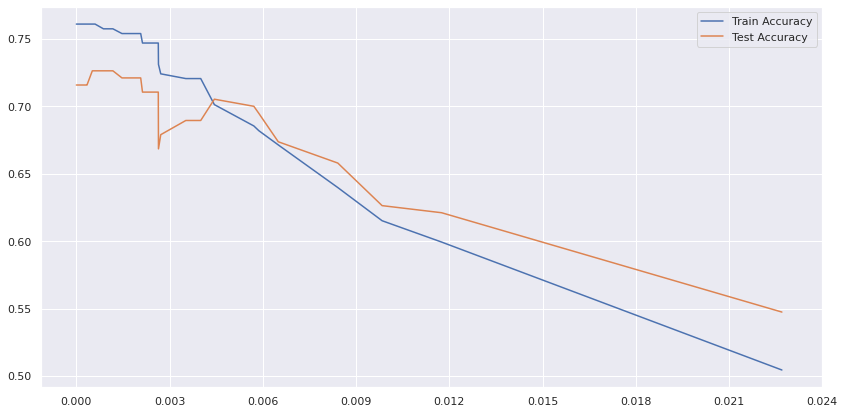

In [84]:
accuracy_train, accuracy_test = [], []

for i in alphas:
  dt = DecisionTreeClassifier(ccp_alpha=i)

  dt.fit(xtrain, ytrain)

  accuracy_train.append(dt.score(xtrain, ytrain))
  accuracy_test.append(dt.score(xtest, ytest))

sns.set()
plt.figure(figsize = (14,7))
sns.lineplot(y=accuracy_train, x=alphas, label = 'Train Accuracy')
sns.lineplot(y=accuracy_test, x=alphas, label = 'Test Accuracy')
plt.xticks(ticks = np.arange(0.00, 0.025, 0.003))
plt.show()
  

It is evident that the ideal value of ```ccp_alpha``` is around 0.001 from the above figure.

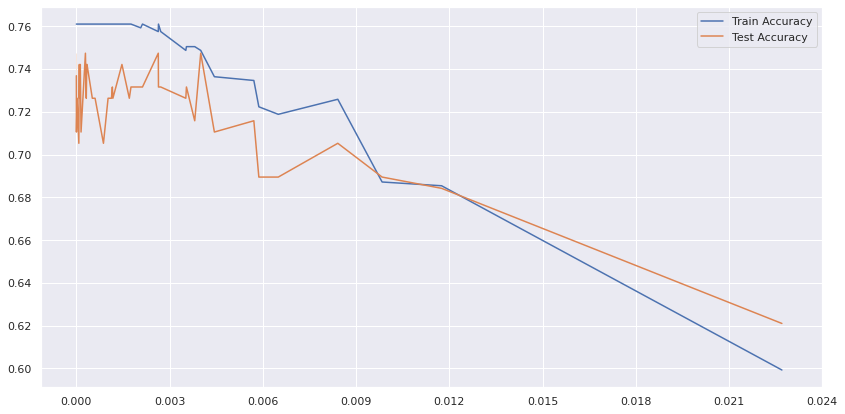

In [90]:
accuracy_train, accuracy_test = [], []

for i in alphas:
  rf = RandomForestClassifier(ccp_alpha=i)

  rf.fit(xtrain, ytrain)

  accuracy_train.append(rf.score(xtrain, ytrain))
  accuracy_test.append(rf.score(xtest, ytest))

sns.set()
plt.figure(figsize = (14,7))
sns.lineplot(y=accuracy_train, x=alphas, label = 'Train Accuracy')
sns.lineplot(y=accuracy_test, x=alphas, label = 'Test Accuracy')
plt.xticks(ticks = np.arange(0.00, 0.025, 0.003))
plt.show()

# Hyperparameter Tuning by GridSearchCV

In [104]:
model_params = {
    'svm': {
        'model': SVC(gamma = 'auto'),
        'params': {
            'C': [0.01, 0.05, 0.1],
            'kernel': ['rbf', 'linear']
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver = 'liblinear', 
                                    multi_class = 'ovr', 
                                    penalty = 'l1'),
        'params': {
            'C': [0.01, 0.05, 0.1]
        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'ccp_alpha': np.arange(0.00, 0.006, 0.0005)
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(n_estimators=100),
        'params': {
            'criterion': ['gini', 'entropy'],
            'ccp_alpha': [0.003, 0.0035, 0.004]
        }
    }
}

In [105]:
from sklearn.model_selection import GridSearchCV

scores = []

for model_name, mp in model_params.items():
  clf = GridSearchCV(mp['model'], mp['params'], cv = 100, return_train_score = False)
  clf.fit(X, y)
  scores.append({
      'model': model_name,
      'best_score': clf.best_score_,
      'best_params': clf.best_params_
  })

In [106]:
results = pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])
results

,model,best_score,best_params
0,svm,0.591607,"{'C': 0.1, 'kernel': 'rbf'}"
1,logistic_regression,0.595536,{'C': 0.05}
2,decision_tree,0.670000,"{'ccp_alpha': 0.0005, 'criterion': 'gini'}"
3,random_forest,0.691071,"{'ccp_alpha': 0.0035, 'criterion': 'entropy'}"


# Validation with Decision Tree

In [110]:
dt = DecisionTreeClassifier(criterion='gini', ccp_alpha=0.0005)
dt.fit(xtrain, ytrain)
print("Decision Tree Test score: ", round(dt.score(xtest, ytest), 4)*100)
print("Decision Tree Train score: ", round(dt.score(xtrain, ytrain), 4)*100)

Decision Tree Test score:  71.58
Decision Tree Train score:  76.1


# Validation with Random Forest

In [111]:
rf = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.0035)
rf.fit(xtrain, ytrain)
print("Random Forest Test score: ", round(rf.score(xtest, ytest), 4)*100)
print("Random Forest Train score: ", round(rf.score(xtrain, ytrain), 4)*100)

Random Forest Test score:  72.11
Random Forest Train score:  75.4


# K-fold Cross Validation

In [89]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(DecisionTreeClassifier(criterion='gini', ccp_alpha = 0.0005), X, y, cv = 100)
print("Cross-val score: ", round(np.average(cv_scores), 4)*100)

Cross-val score:  67.0


In [116]:
cv_scores = cross_val_score(RandomForestClassifier(criterion='entropy', ccp_alpha = 0.0035), X, y, cv = 100)
print("Cross-val score: ", round(np.average(cv_scores), 4)*100)

Cross-val score:  67.86


# Summarizing Results:
- Best Fit Model: **Random Forest**
- Best Fit Model Parameters:
  - ```criterion = 'entropy'```
  - ```ccp_alpha = 0.0035```
- Training set score **(before Pruning)**: 76.10
- Testing set score **(before Pruning)**: 74.74
- GridSearchCV score = 69.10 (with ```CV = 100```)
- Training set score **(after Pruning and CV)**: 75.4
- Testing set score **(after Pruning and CV)**: 72.11
- 100-Fold Cross Validation Score: 67.86


In [117]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Bitcoin-Sentiment-Analysis.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Bitcoin-Sentiment-Analysis.ipynb to pdf
[NbConvertApp] Support files will be in Bitcoin-Sentiment-Analysis_files/
[NbConvertApp] Making directory ./Bitcoin-Sentiment-Analysis_files
[NbConvertApp] Making directory ./Bitcoin-Sentiment-Analysis_files
[NbConvertApp] Making directory ./Bitcoin-Sentiment-Analysis_files
[NbConvertApp] Making directory ./Bitcoin-Sentiment-Analysis_files
[NbConvertApp] Writing 79325 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 180557 bytes to /content/drive/My Drive/Bitcoin-Sentiment-Analysis.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'